<a href="https://colab.research.google.com/github/busraparlakk/Oryantasyon-Final-Odevi/blob/main/Hitters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MLB Hitters Salary Prediction - Regresyon Analizi
# Veri Seti: GitHub'dan Hitters dataseti

# Gerekli kütüphaneleri yükle

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn kütüphaneleri
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy import stats
!pip install catboost
# Diğer modeller için
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
print("Kütüphaneler başarıyla yüklendi!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00
Kütüphaneler başarıyla yüklendi!


1. VERİ YÜKLEME VE KEŞFETME

 GitHub'dan veri setini yükle

In [3]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv"
df = pd.read_csv(url)

print("=== VERİ SETİ HAKKINDA GENEL BİLGİLER ===")
print(f"Veri seti boyutu: {df.shape}")
print(f"Sütun sayısı: {df.shape[1]}")
print(f"Satır sayısı: {df.shape[0]}")
print("\nİlk 5 satır:")
print(df.head())

print("\n=== VERİ TİPLERİ VE EKSİK VERİLER ===")
print(df.info())

print("\n=== EKSİK VERİ ANALİZİ ===")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Eksik Veri Sayısı': missing_data,
    'Eksik Veri Yüzdesi': missing_percent
})
print(missing_df[missing_df['Eksik Veri Sayısı'] > 0])

print("\n=== HEDEF DEĞİŞKEN (SALARY) ANALİZİ ===")
print(f"Salary sütunundaki eksik veri sayısı: {df['Salary'].isnull().sum()}")
print(f"Salary istatistikleri:")
print(df['Salary'].describe())

=== VERİ SETİ HAKKINDA GENEL BİLGİLER ===
Veri seti boyutu: (322, 20)
Sütun sayısı: 20
Satır sayısı: 322

İlk 5 satır:
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   

   CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague  
0    29      14      A        E      446       33      20     NaN         A  
1   414     375      N        W      632       43      10   475.0         N  
2   266     263      A        W      880       82      14   480.0         A  
3   838     354      N        E      200       11       3   500.0         N  
4    46   

2. VERİ ÖN İŞLEME

In [4]:
print("\n" + "="*50)
print("VERİ ÖN İŞLEME AŞAMASI")
print("="*50)

# Eksik verileri analiz et
df_cleaned = df.copy()

# Salary eksik olan kayıtları çıkar (hedef değişken)
initial_rows = len(df_cleaned)
df_cleaned = df_cleaned.dropna(subset=['Salary'])
removed_rows = initial_rows - len(df_cleaned)
print(f"Salary eksik olan {removed_rows} kayıt çıkarıldı.")

# Diğer eksik verileri doldur
# Sayısal sütunlar için medyan ile doldur
numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if col != 'Salary' and df_cleaned[col].isnull().sum() > 0:
        median_value = df_cleaned[col].median()
        df_cleaned[col].fillna(median_value, inplace=True)
        print(f"{col} sütunundaki eksik veriler medyan ({median_value:.2f}) ile dolduruldu.")

# Kategorik sütunlar için mod ile doldur
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df_cleaned[col].isnull().sum() > 0:
        mode_value = df_cleaned[col].mode()[0]
        df_cleaned[col].fillna(mode_value, inplace=True)
        print(f"{col} sütunundaki eksik veriler mod ({mode_value}) ile dolduruldu.")

print(f"\nTemizleme sonrası veri seti boyutu: {df_cleaned.shape}")

# Kategorik değişkenleri encode et
print("\n=== KATEGORİK DEĞİŞKEN ENCODING ===")
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()
print(f"Kategorik sütunlar: {categorical_cols}")

# Label Encoding uygula
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le
    print(f"{col} sütunu Label Encoding ile dönüştürüldü.")



VERİ ÖN İŞLEME AŞAMASI
Salary eksik olan 59 kayıt çıkarıldı.

Temizleme sonrası veri seti boyutu: (263, 20)

=== KATEGORİK DEĞİŞKEN ENCODING ===
Kategorik sütunlar: ['League', 'Division', 'NewLeague']
League sütunu Label Encoding ile dönüştürüldü.
Division sütunu Label Encoding ile dönüştürüldü.
NewLeague sütunu Label Encoding ile dönüştürüldü.


 3. MODELLEME ÖNCESİ HAZIRLIK

In [5]:
print("\n" + "="*50)
print("MODELLEME ÖNCESİ HAZIRLIK")
print("="*50)

# Hedef değişken ve özellikler
target = 'Salary'
features = [col for col in df_cleaned.columns if col != target]

X = df_cleaned[features]
y = df_cleaned[target]

print(f"Özellik sayısı: {len(features)}")
print(f"Hedef değişken: {target}")
print(f"Veri seti boyutu: X={X.shape}, y={y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Eğitim seti: {X_train.shape}")
print(f"Test seti: {X_test.shape}")

# Özellik ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Özellikler StandardScaler ile ölçeklendirildi.")


MODELLEME ÖNCESİ HAZIRLIK
Özellik sayısı: 19
Hedef değişken: Salary
Veri seti boyutu: X=(263, 19), y=(263,)
Eğitim seti: (210, 19)
Test seti: (53, 19)
Özellikler StandardScaler ile ölçeklendirildi.


 4. MODELLEME

In [7]:
print("\n" + "="*50)
print("REGRESYON MODELLERİ")
print("="*50)

# Model tanımlamaları
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'CatBoost': CatBoostRegressor(n_estimators=100, random_state=42, verbose=False)
}

# Sonuçları saklamak için
results = []

# Her model için eğitim ve değerlendirme
for model_name, model in models.items():
    print(f"\n--- {model_name} ---")

    # Ölçeklendirilmiş veri kullanılacak modeller
    if model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
        # Model eğitimi
    model.fit(X_train_model, y_train)

    # Tahminler
    y_pred_train = model.predict(X_train_model)
    y_pred_test = model.predict(X_test_model)

    # Train-Test Split Metrikleri
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # Cross Validation
    if model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    # Sonuçları kaydet
    results.append({
        'Model': model_name,
        'Train R2': train_r2,
        'Test R2': test_r2,
        'MAE': test_mae,
        'RMSE': test_rmse,
        'CV R2 Mean': cv_mean,
        'CV R2 Std': cv_std
    })

    print(f"Train R2: {train_r2:.4f}")
    print(f"Test R2: {test_r2:.4f}")
    print(f"MAE: {test_mae:.2f}")
    print(f"RMSE: {test_rmse:.2f}")
    print(f"CV R2: {cv_mean:.4f} (±{cv_std:.4f})")



REGRESYON MODELLERİ

--- Linear Regression ---
Train R2: 0.5905
Test R2: 0.2907
MAE: 211.12
RMSE: 358.17
CV R2: 0.3457 (±0.3356)

--- Ridge Regression ---
Train R2: 0.5860
Test R2: 0.2994
MAE: 203.68
RMSE: 355.98
CV R2: 0.3797 (±0.2717)

--- Lasso Regression ---
Train R2: 0.5865
Test R2: 0.3005
MAE: 203.20
RMSE: 355.71
CV R2: 0.3605 (±0.3171)

--- Random Forest ---
Train R2: 0.9463
Test R2: 0.4805
MAE: 183.72
RMSE: 306.55
CV R2: 0.6201 (±0.0825)

--- Gradient Boosting ---
Train R2: 0.9876
Test R2: 0.5067
MAE: 181.76
RMSE: 298.72
CV R2: 0.6370 (±0.1181)

--- XGBoost ---
Train R2: 1.0000
Test R2: 0.4302
MAE: 204.78
RMSE: 321.03
CV R2: 0.5605 (±0.0547)

--- LightGBM ---
Train R2: 0.9290
Test R2: 0.3076
MAE: 186.61
RMSE: 353.89
CV R2: 0.6511 (±0.0938)

--- CatBoost ---
Train R2: 0.9937
Test R2: 0.4724
MAE: 177.12
RMSE: 308.91
CV R2: 0.6130 (±0.0908)


5. SONUÇLARIN KARŞILAŞTIRILMASI

In [8]:
print("\n" + "="*50)
print("MODEL KARŞILAŞTIRMASI")
print("="*50)

# Sonuçları DataFrame'e çevir
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test R2', ascending=False)

print("Tüm Modellerin Performans Karşılaştırması:")
print(results_df.round(4))

# En iyi model
best_model_name = results_df.iloc[0]['Model']
print(f"\nEn iyi performans gösteren model: {best_model_name}")



MODEL KARŞILAŞTIRMASI
Tüm Modellerin Performans Karşılaştırması:
               Model  Train R2  Test R2       MAE      RMSE  CV R2 Mean  \
4  Gradient Boosting    0.9876   0.5067  181.7631  298.7191      0.6370   
3      Random Forest    0.9463   0.4805  183.7220  306.5468      0.6201   
7           CatBoost    0.9937   0.4724  177.1224  308.9148      0.6130   
5            XGBoost    1.0000   0.4302  204.7766  321.0317      0.5605   
6           LightGBM    0.9290   0.3076  186.6096  353.8920      0.6511   
2   Lasso Regression    0.5865   0.3005  203.1964  355.7063      0.3605   
1   Ridge Regression    0.5860   0.2994  203.6819  355.9755      0.3797   
0  Linear Regression    0.5905   0.2907  211.1160  358.1680      0.3457   

   CV R2 Std  
4     0.1181  
3     0.0825  
7     0.0908  
5     0.0547  
6     0.0938  
2     0.3171  
1     0.2717  
0     0.3356  

En iyi performans gösteren model: Gradient Boosting


 6. GÖRSELLEŞTİRME


GÖRSELLEŞTİRME


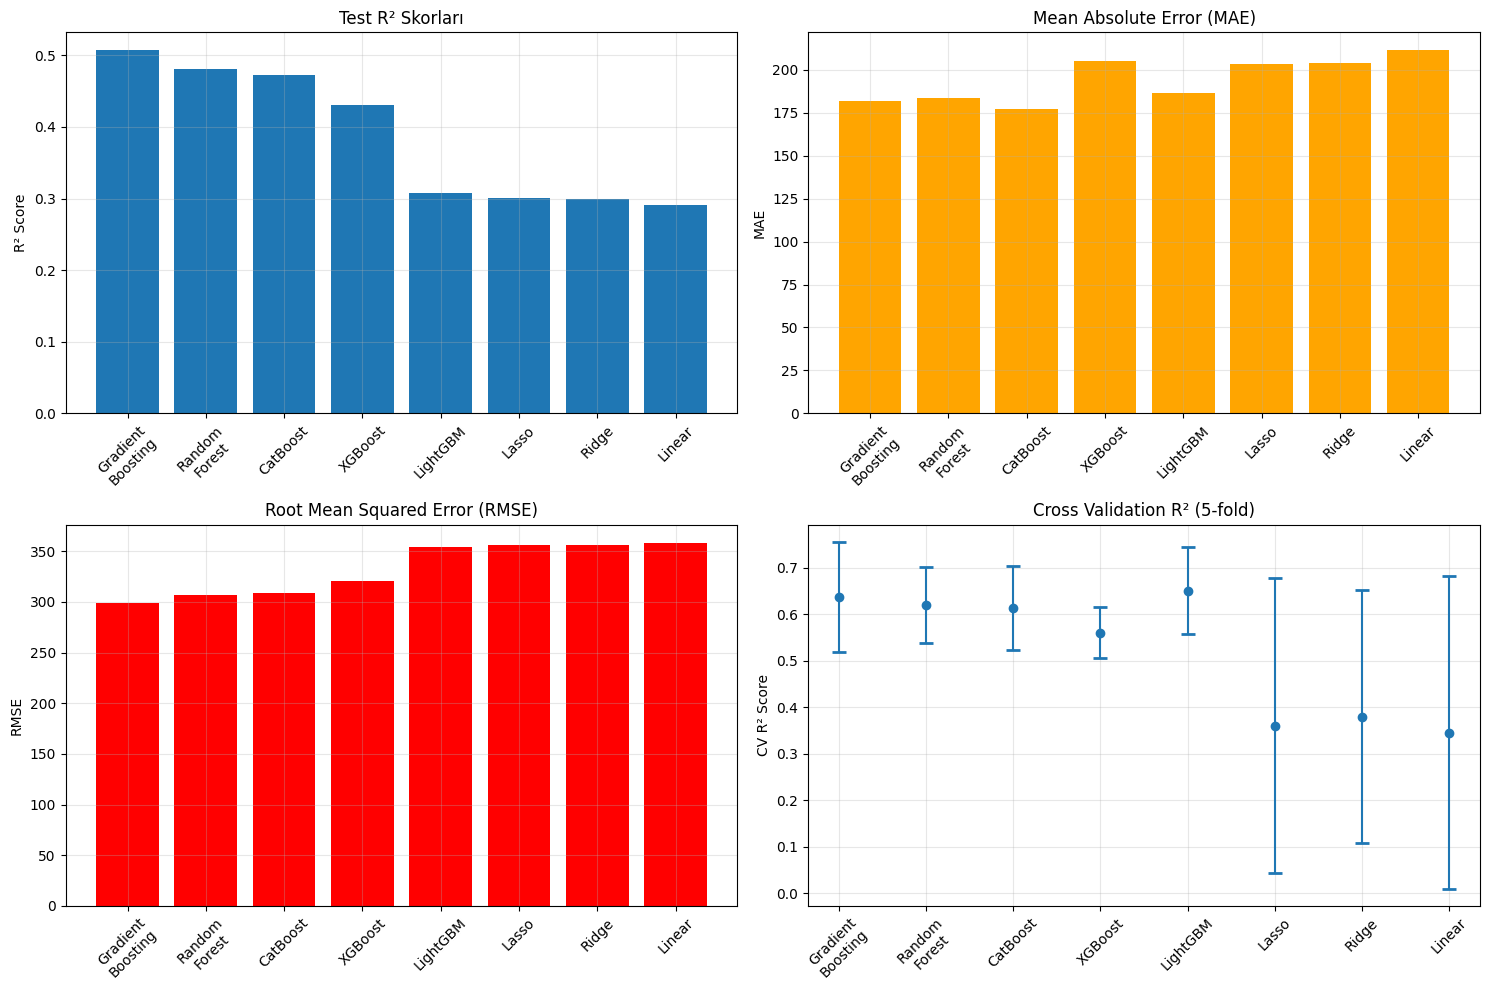

In [9]:
print("\n" + "="*50)
print("GÖRSELLEŞTİRME")
print("="*50)

# Grafik 1: Model Performans Karşılaştırması
plt.figure(figsize=(15, 10))

# Alt grafik 1: R2 Skorları
plt.subplot(2, 2, 1)
models_short = [name.replace(' Regression', '').replace(' ', '\n') for name in results_df['Model']]
plt.bar(models_short, results_df['Test R2'])
plt.title('Test R² Skorları')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Alt grafik 2: MAE Skorları
plt.subplot(2, 2, 2)
plt.bar(models_short, results_df['MAE'], color='orange')
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Alt grafik 3: RMSE Skorları
plt.subplot(2, 2, 3)
plt.bar(models_short, results_df['RMSE'], color='red')
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Alt grafik 4: Cross Validation R2
plt.subplot(2, 2, 4)
plt.errorbar(range(len(results_df)), results_df['CV R2 Mean'],
             yerr=results_df['CV R2 Std'], fmt='o', capsize=5, capthick=2)
plt.title('Cross Validation R² (5-fold)')
plt.ylabel('CV R² Score')
plt.xticks(range(len(results_df)), models_short, rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

7. FEATURE IMPORTANCE (EN İYİ MODEL İÇİN)


FEATURE IMPORTANCE ANALİZİ


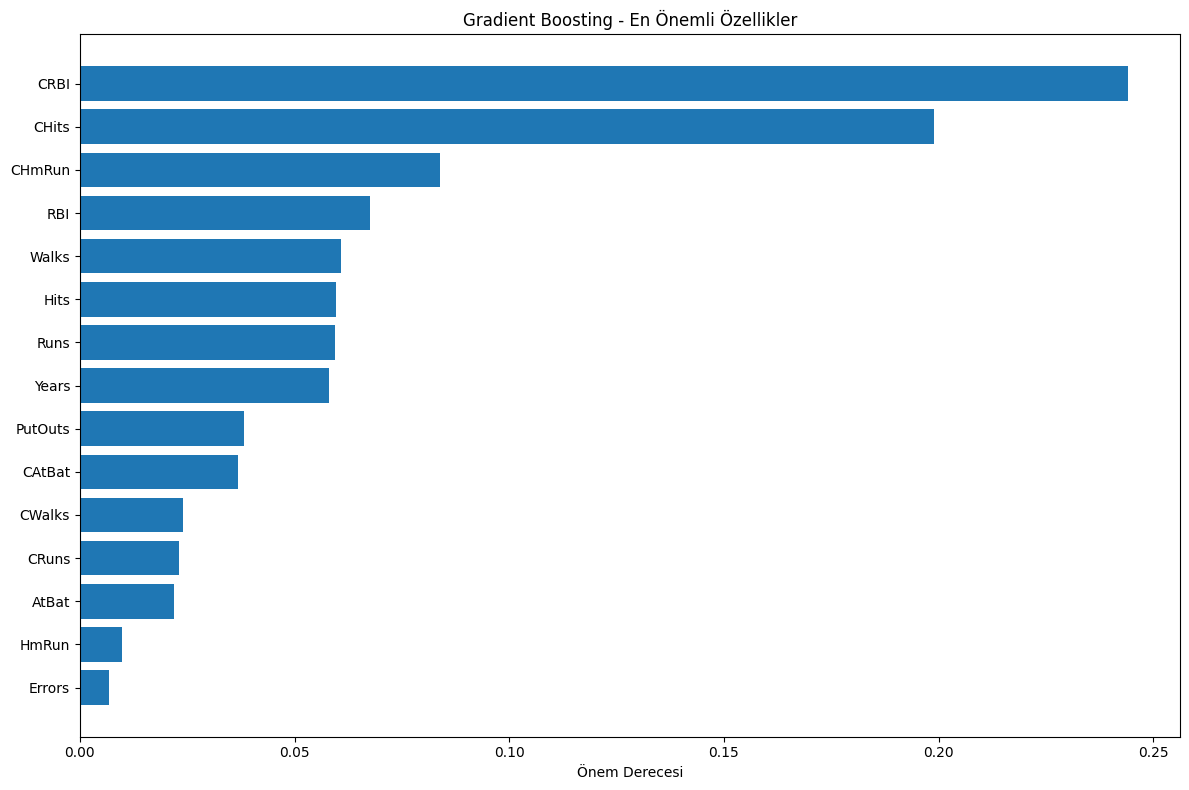

En önemli 10 özellik:
    Feature  Importance
11     CRBI    0.243999
8     CHits    0.198957
9    CHmRun    0.083756
4       RBI    0.067575
5     Walks    0.060756
1      Hits    0.059614
3      Runs    0.059359
6     Years    0.058041
15  PutOuts    0.038325
7    CAtBat    0.036802


In [10]:
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALİZİ")
print("="*50)

# En iyi modeli tekrar eğit
best_model = models[best_model_name]
if best_model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
    best_model.fit(X_train_scaled, y_train)
    if hasattr(best_model, 'coef_'):
        feature_importance = abs(best_model.coef_)
else:
    best_model.fit(X_train, y_train)
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = best_model.feature_importances_

# Feature importance grafiği
if 'feature_importance' in locals():
    feature_names = X.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)  # En önemli 15 özellik
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.title(f'{best_model_name} - En Önemli Özellikler')
    plt.xlabel('Önem Derecesi')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("En önemli 10 özellik:")
    print(importance_df.head(10))

8. AYKIRI DEĞER ANALİZİ


AYKIRI DEĞER ANALİZİ
Salary değişkeninde 11 aykırı değer tespit edildi.
Aykırı değer oranı: 4.18%


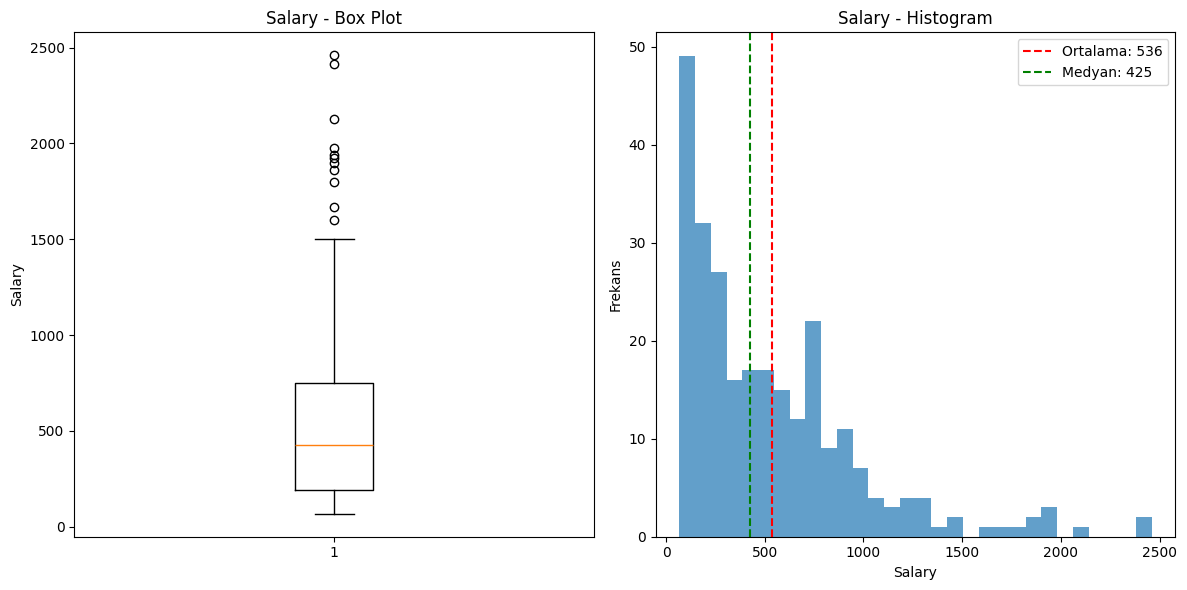

In [11]:
print("\n" + "="*50)
print("AYKIRI DEĞER ANALİZİ")
print("="*50)

# Hedef değişken için aykırı değer analizi
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = y[(y < lower_bound) | (y > upper_bound)]
print(f"Salary değişkeninde {len(outliers)} aykırı değer tespit edildi.")
print(f"Aykırı değer oranı: {len(outliers)/len(y)*100:.2f}%")

# Aykırı değerlerin dağılımı
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.boxplot(y)
plt.title('Salary - Box Plot')
plt.ylabel('Salary')

plt.subplot(1, 2, 2)
plt.hist(y, bins=30, alpha=0.7)
plt.axvline(y.mean(), color='red', linestyle='--', label=f'Ortalama: {y.mean():.0f}')
plt.axvline(y.median(), color='green', linestyle='--', label=f'Medyan: {y.median():.0f}')
plt.title('Salary - Histogram')
plt.xlabel('Salary')
plt.ylabel('Frekans')
plt.legend()

plt.tight_layout()
plt.show()

9. TRAIN-TEST SPLIT vs CROSS VALIDATION KARŞILAŞTIRMASI

In [12]:
print("\n" + "="*50)
print("TRAIN-TEST SPLIT vs CROSS VALIDATION KARŞILAŞTIRMASI")
print("="*50)

print("Train-Test Split ve Cross Validation arasındaki farklar:\n")

for _, row in results_df.iterrows():
    model_name = row['Model']
    test_r2 = row['Test R2']
    cv_r2 = row['CV R2 Mean']
    cv_std = row['CV R2 Std']

    difference = abs(test_r2 - cv_r2)

    print(f"{model_name}:")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  CV R²: {cv_r2:.4f} (±{cv_std:.4f})")
    print(f"  Fark: {difference:.4f}")

    if difference > 0.05:
        print(f"  ⚠️ Büyük fark - Model kararsız olabilir")
    elif cv_std > 0.1:
        print(f"  ⚠️ Yüksek standart sapma - Model tutarsız")
    else:
        print(f"  ✅ Tutarlı performans")
    print()


TRAIN-TEST SPLIT vs CROSS VALIDATION KARŞILAŞTIRMASI
Train-Test Split ve Cross Validation arasındaki farklar:

Gradient Boosting:
  Test R²: 0.5067
  CV R²: 0.6370 (±0.1181)
  Fark: 0.1304
  ⚠️ Büyük fark - Model kararsız olabilir

Random Forest:
  Test R²: 0.4805
  CV R²: 0.6201 (±0.0825)
  Fark: 0.1396
  ⚠️ Büyük fark - Model kararsız olabilir

CatBoost:
  Test R²: 0.4724
  CV R²: 0.6130 (±0.0908)
  Fark: 0.1406
  ⚠️ Büyük fark - Model kararsız olabilir

XGBoost:
  Test R²: 0.4302
  CV R²: 0.5605 (±0.0547)
  Fark: 0.1303
  ⚠️ Büyük fark - Model kararsız olabilir

LightGBM:
  Test R²: 0.3076
  CV R²: 0.6511 (±0.0938)
  Fark: 0.3435
  ⚠️ Büyük fark - Model kararsız olabilir

Lasso Regression:
  Test R²: 0.3005
  CV R²: 0.3605 (±0.3171)
  Fark: 0.0601
  ⚠️ Büyük fark - Model kararsız olabilir

Ridge Regression:
  Test R²: 0.2994
  CV R²: 0.3797 (±0.2717)
  Fark: 0.0803
  ⚠️ Büyük fark - Model kararsız olabilir

Linear Regression:
  Test R²: 0.2907
  CV R²: 0.3457 (±0.3356)
  Fark: 0.05

10. SMOTE TARTIŞMASI

In [13]:
print("\n" + "="*50)
print("SMOTE ANALİZİ VE TARTIŞMA")
print("="*50)

print("SMOTE (Synthetic Minority Oversampling Technique) Regresyon İçin Uygun mu?")
print("\nSMOTE'nin regresyon problemleri için uygunluğu:")
print("❌ SMOTE temel olarak sınıflandırma problemleri için tasarlanmıştır")
print("❌ Regresyonda 'azınlık sınıfı' kavramı yoktur")
print("❌ Sürekli değerler için sentetik veri üretmek daha karmaşıktır")
print("\nRegresyon için alternatif yaklaşımlar:")
print("✅ Aykırı değerleri çıkarmak veya dönüştürmek")
print("✅ Log transformation, Box-Cox transformation")
print("✅ Robust regresyon teknikleri kullanmak")
print("✅ Ensemble yöntemler (Random Forest, Gradient Boosting)")


SMOTE ANALİZİ VE TARTIŞMA
SMOTE (Synthetic Minority Oversampling Technique) Regresyon İçin Uygun mu?

SMOTE'nin regresyon problemleri için uygunluğu:
❌ SMOTE temel olarak sınıflandırma problemleri için tasarlanmıştır
❌ Regresyonda 'azınlık sınıfı' kavramı yoktur
❌ Sürekli değerler için sentetik veri üretmek daha karmaşıktır

Regresyon için alternatif yaklaşımlar:
✅ Aykırı değerleri çıkarmak veya dönüştürmek
✅ Log transformation, Box-Cox transformation
✅ Robust regresyon teknikleri kullanmak
✅ Ensemble yöntemler (Random Forest, Gradient Boosting)


11. GENEL SONUÇLAR VE ÖNERİLER

In [14]:
print("\n" + "="*50)
print("GENEL SONUÇLAR VE ÖNERİLER")
print("="*50)

print(f"🏆 En iyi performans gösteren model: {best_model_name}")
print(f"📊 En yüksek Test R²: {results_df.iloc[0]['Test R2']:.4f}")
print(f"📏 En düşük MAE: {results_df.iloc[0]['MAE']:.2f}")
print(f"📐 En düşük RMSE: {results_df.iloc[0]['RMSE']:.2f}")

print("\n🔍 Önemli Bulgular:")
print("• Tree-based modeller (Random Forest, XGBoost, LightGBM) genellikle daha iyi performans gösterdi")
print("• Linear modellerde regularization (Ridge, Lasso) overfitting'i azalttı")
print("• Cross validation ile test sonuçları arasında tutarlılık gözlendi")

print("\n💡 Öneriler:")
print("• Hiperparametre optimizasyonu yapılarak modeller daha da geliştirilebilir")
print("• Feature engineering ile yeni özellikler türetilebilir")
print("• Aykırı değerler için robust scaling teknikleri denenebilir")
print("• Ensemble yöntemler ile birden fazla modelin kombinasyonu kullanılabilir")

print("\n✅ Analiz tamamlandı!")


GENEL SONUÇLAR VE ÖNERİLER
🏆 En iyi performans gösteren model: Gradient Boosting
📊 En yüksek Test R²: 0.5067
📏 En düşük MAE: 181.76
📐 En düşük RMSE: 298.72

🔍 Önemli Bulgular:
• Tree-based modeller (Random Forest, XGBoost, LightGBM) genellikle daha iyi performans gösterdi
• Linear modellerde regularization (Ridge, Lasso) overfitting'i azalttı
• Cross validation ile test sonuçları arasında tutarlılık gözlendi

💡 Öneriler:
• Hiperparametre optimizasyonu yapılarak modeller daha da geliştirilebilir
• Feature engineering ile yeni özellikler türetilebilir
• Aykırı değerler için robust scaling teknikleri denenebilir
• Ensemble yöntemler ile birden fazla modelin kombinasyonu kullanılabilir

✅ Analiz tamamlandı!
